<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/splines_numpyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1d regression splines 

We illustrate 1d regression splines using the cherry blossom example in sec 4.5  of [Statistical Rethinking ed 2](https://xcelab.net/rm/statistical-rethinking/). 
The numpyro code is from [Du Phan's site](https://fehiepsi.github.io/rethinking-numpyro/04-geocentric-models.html).

In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro
!pip install -q arviz

     |████████████████████████████████| 1.6MB 11.9MB/s 
     |████████████████████████████████| 4.7MB 70.2MB/s 
     |████████████████████████████████| 768kB 61.3MB/s 
     |████████████████████████████████| 317kB 70.8MB/s 


In [2]:

import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
import math
import os
import warnings
import pandas as pd

from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax
print("jax version {}".format(jax.__version__))
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))

import jax.numpy as jnp
from jax import random, vmap

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.distributions.transforms import AffineTransform
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive
from numpyro.infer import MCMC, NUTS
from numpyro.infer import SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim


import arviz as az

jax version 0.2.12
jax backend cpu


# Data

In [23]:

url = 'https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/cherry_blossoms.csv'
cherry_blossoms = pd.read_csv(url, sep=';')
df = cherry_blossoms

display(df.sample(n=5, random_state=1))
display(df.describe())


,year,doy,temp,temp_upper,temp_lower
838,1639,108.0,5.65,6.38,4.92
776,1577,100.0,6.45,7.10,5.81
341,1142,NaN,6.04,7.34,4.74
1003,1804,104.0,5.30,5.99,4.61
186,987,NaN,5.79,7.64,3.95


,year,doy,temp,temp_upper,temp_lower
count,1215.000000,827.000000,1124.000000,1124.000000,1124.000000
mean,1408.000000,104.540508,6.141886,7.185151,5.098941
std,350.884596,6.407036,0.663648,0.992921,0.850350
min,801.000000,86.000000,4.670000,5.450000,0.750000
25%,1104.500000,100.000000,5.700000,6.480000,4.610000
50%,1408.000000,105.000000,6.100000,7.040000,5.145000
75%,1711.500000,109.000000,6.530000,7.720000,5.542500
max,2015.000000,124.000000,8.300000,12.100000,7.740000


In [25]:
df2 = df[df.doy.notna()]  # complete cases on doy (day of year)
x = df2.year.values.astype(float)
y = df2.doy.values.astype(float)
xlabel = 'year'
ylabel = 'doy'

# B-splines 

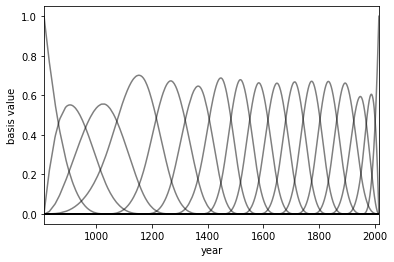

In [75]:
def make_splines(x, num_knots, degree=3):
  knot_list = jnp.quantile(x, q=jnp.linspace(0, 1, num=num_knots))
  knots = jnp.pad(knot_list, (3, 3), mode="edge")
  B = BSpline(knots, jnp.identity(num_knots + 2), k=degree)(x)
  return B


def plot_basis(x, B, w=None):
  if w is None: w = jnp.ones((B.shape[1]))
  fig, ax = plt.subplots()
  ax.set_xlim(np.min(x), np.max(x))
  ax.set_xlabel(xlabel)
  ax.set_ylabel("basis value")
  for i in range(B.shape[1]):
      ax.plot(x, (w[i] * B[:, i]), "k", alpha=0.5)
  return ax

nknots = 15
B =  make_splines(x, nknots)
ax = plot_basis(x, B)
plt.savefig(f'splines_basis_{nknots}_{ylabel}.pdf', dpi=300)



In [84]:
num_knots = 15
degree = 3

knot_list = jnp.quantile(x, q=jnp.linspace(0, 1, num=num_knots))
print(knot_list)
print(knot_list.shape)

knots = jnp.pad(knot_list, (3, 3), mode="edge")
print(knots)
print(knots.shape)

B = BSpline(knots, jnp.identity(num_knots + 2), k=degree)(x)
print(B.shape)

[ 839.     937.214 1017.429 1097.643 1177.857 1258.071 1338.286 1418.5
 1498.714 1578.929 1659.143 1739.357 1819.571 1899.786 1980.   ]
(15,)
[ 839.     839.     839.     839.     937.214 1017.429 1097.643 1177.857
 1258.071 1338.286 1418.5   1498.714 1578.929 1659.143 1739.357 1819.571
 1899.786 1980.    1980.    1980.    1980.   ]
(21,)
(1124, 17)


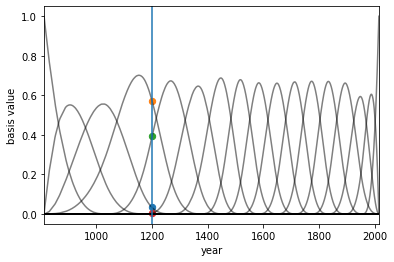

In [69]:
def plot_basis_with_vertical_line(x, B, xstar):
  ax = plot_basis(x, B)
  num_knots = B.shape[1]
  ndx = np.where(x==xstar)[0][0]
  for i in range(num_knots):
    yy = B[ndx,i]
    if yy>0:
      ax.scatter(xstar, yy, s=40)
  ax.axvline(x=xstar)
  return ax

plot_basis_with_vertical_line(x, B, 1200)
plt.savefig(f'splines_basis_{nknots}_vertical_{ylabel}.pdf', dpi=300)

100%|██████████| 20000/20000 [00:11<00:00, 1708.49it/s, init loss: 190557520.0000, avg. loss [19001-20000]: 2704.7454]


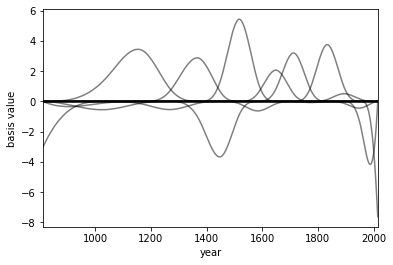

In [70]:



def model(B, y, offset=100):
    a = numpyro.sample("a", dist.Normal(offset, 10))
    w = numpyro.sample("w", dist.Normal(0, 10).expand(B.shape[1:]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + B @ w)
    #mu = numpyro.deterministic("mu", a + jnp.sum(B * w, axis=-1)) # equivalent
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)

def fit_model(B, y, offset=100):
  start = {"w": jnp.zeros(B.shape[1])}
  guide = AutoLaplaceApproximation(model, init_loc_fn=init_to_value(values=start))
  svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), B=B, y=y, offset=offset)
  params, losses = svi.run(random.PRNGKey(0), 20000) # needs 20k iterations 
  post = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
  return post

post = fit_model(B, y)
w = jnp.mean(post["w"], 0)
plot_basis(x, B, w)
plt.savefig(f'splines_basis_weighted_{nknots}_{ylabel}.pdf', dpi=300)



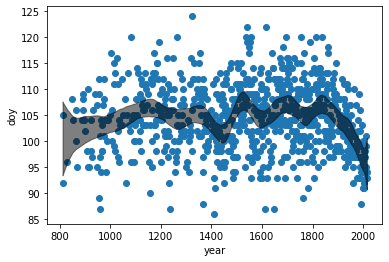

<Figure size 432x288 with 0 Axes>

In [71]:
def plot_post_pred(post, x, y):
  mu = post["mu"]
  mu_PI = jnp.percentile(mu, q=(1.5, 98.5), axis=0)
  plt.figure()
  plt.scatter(x, y)
  plt.fill_between(x, mu_PI[0], mu_PI[1], color="k", alpha=0.5)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

plot_post_pred(post, x, y)
plt.savefig(f'splines_post_pred_{nknots}_{ylabel}.pdf', dpi=300)

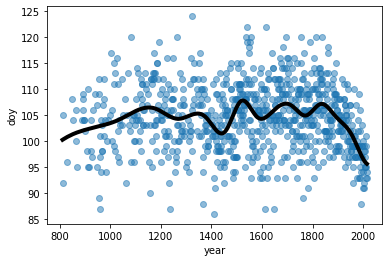

In [72]:
a = jnp.mean(post["a"], 0)
w = jnp.mean(post["w"], 0)
mu = a + B @ w


def plot_pred(mu, x, y):
  plt.figure()
  plt.scatter(x, y, alpha=0.5)
  plt.plot(x, mu, 'k-', linewidth=4)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

plot_pred(mu, x, y)
plt.savefig(f'splines_point_pred_{nknots}_{ylabel}.pdf', dpi=300)

# Repeat with temperature as target variable

In [79]:
df2 = df[df.temp.notna()]  # complete cases 
x = df2.year.values.astype(float)
y = df2.temp.values.astype(float)
xlabel = 'year'
ylabel = 'temp'

100%|██████████| 20000/20000 [00:11<00:00, 1703.90it/s, init loss: 449479.4688, avg. loss [19001-20000]: 671.3029] 


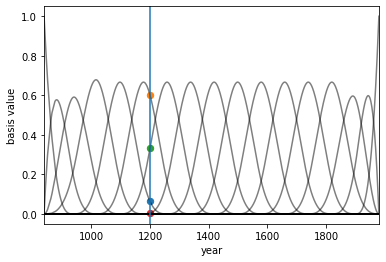

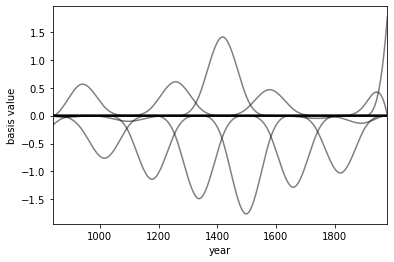

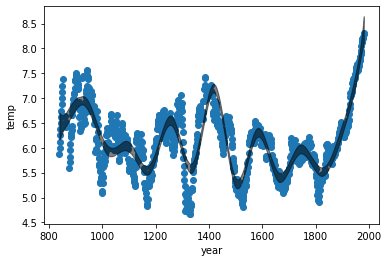

<Figure size 432x288 with 0 Axes>

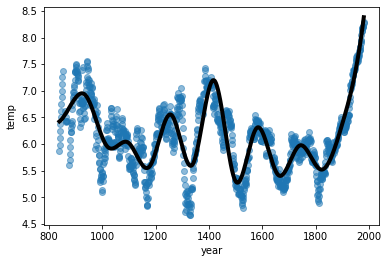

In [88]:
nknots = 15

B =  make_splines(x, nknots)
plot_basis_with_vertical_line(x, B, 1200)
plt.savefig(f'splines_basis_{nknots}_vertical_{ylabel}.pdf', dpi=300)


post = fit_model(B, y, offset=6)
w = jnp.mean(post["w"], 0)
plot_basis(x, B, w)
plt.savefig(f'splines_basis_weighted_{nknots}_{ylabel}.pdf', dpi=300)

plot_post_pred(post, x, y)
plt.savefig(f'splines_post_pred_{nknots}_{ylabel}.pdf', dpi=300)

a = jnp.mean(post["a"], 0)
w = jnp.mean(post["w"], 0)
mu = a + B @ w
plot_pred(mu, x, y)
plt.savefig(f'splines_point_pred_{nknots}_{ylabel}.pdf', dpi=300)

# Maximum likelihood estimation

In [92]:
from sklearn.linear_model import LinearRegression, Ridge
#reg = LinearRegression().fit(B, y)
reg = Ridge().fit(B, y)
w = reg.coef_
a = reg.intercept_
print(w)
print(a)

[ 0.07   0.352  1.037 -0.67  -0.036 -1.208  0.938 -1.638  2.058 -2.032
  0.714 -1.413  0.046 -1.11  -0.051  1.058  1.884]
6.314983941398646


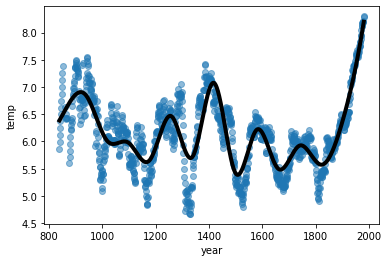

In [93]:
mu = a + B @ w
plot_pred(mu, x, y)
plt.savefig(f'splines_MLE_{nknots}_{ylabel}.pdf', dpi=300)